In [1]:
import os
import sys
import numpy as np

import umap.umap_ as umap

%load_ext autoreload
%autoreload 2

#add the parent folder to sys path so we can import from the notebook subfolder
sys.path.insert(0,'..')


BASEDIR = ""
TIFDIR = "/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo_full"
#TIFDIR = "/home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/NC_s4r2"
EXT='.tiff'

image_directory = os.path.join(BASEDIR, TIFDIR)
output_directory = os.path.join(image_directory, "outputs")

if not os.path.isdir(output_directory):
    os.mkdir(output_directory)
#image_directory = ALLDIR

import xfmreadout.processops as processops
import xfmreadout.clustering as clustering
import xfmreadout.visualisations as vis

FORCE_EMBED=True
FORCE_CLUST=True
OVERWRITE=True

elements, data, dims, sd, sd_dims = processops.compile(image_directory)

#data, dims = processops.data_crop(data, dims, 100, 500, 150, 350)
data, dims = processops.data_crop(data, dims, 1500, 2000, 890, 1090)
sd, sd_dims = processops.data_crop(sd, sd_dims, 1500, 2000, 890, 1090)

weights = np.ones(data.shape[1], dtype=np.float32)
weights = processops.calc_weights(data, weights, do_sqrt=False)

/home/lachlan/.pyenv/versions/3.10.6/envs/venv_xfmread/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/lachlan/.pyenv/versions/3.10.6/envs/venv_xfmread/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/lachlan/.pyenv/versions/

-----------------
BEGIN reading processed data
Location: /home/lachlan/CODEBASE/ReadoutXFM/data/processed_maps/nf_demo_full
-----
Map files found: 21
Elements identified: ['Al', 'As', 'Back', 'Ca', 'Cl', 'Compton', 'Cr', 'Cu', 'Fe', 'K', 'Mn', 'Mo', 'MoL', 'Ni', 'P', 'S', 'Si', 'Ti', 'V', 'Zn', 'sum']
-----------------
READING MAP DATA
Initial shape: (1166, 2048, 21)
Revised shape: (1092, 2048, 21)
-----
-----------------
READING VARIANCE DATA
Initial shape: (583, 1024, 21)
Revised shape: (546, 1024, 21)
-----
(559104, 21)
data0 (2236416,)
datafull (2236416, 21)
Al -- dataq99: 7.223, sdq2: 3.934, max: 7.816
Gaussian averaging, cycle 0 -- dataq99: 7.223, sdq2: 3.934, ratio: 3.672
(2236416,)
Gaussian averaging, cycle 1 -- dataq99: 3.230, sdq2: 1.329, ratio: 4.861
(2236416,)
Gaussian averaging, cycle 2 -- dataq99: 1.445, sdq2: 1.152, ratio: 2.509
(2236416,)
Gaussian averaging, cycle 3 -- dataq99: 0.646, sdq2: 1.092, ratio: 1.184
(2236416,)
As -- dataq99: 0.040, sdq2: 0.096, max: 1.498
Bac

(100000,)
ELEMENT MAP: Al
(0), Al, max: 1.00, 98: 0.63, avg: 0.35


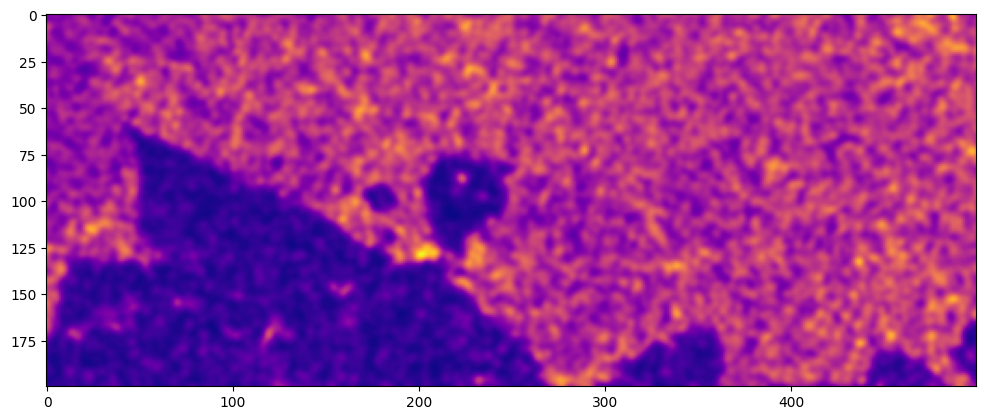

(100000,)
ELEMENT MAP: Al
(0), Al, max: 0.64, 98: 0.44, avg: 0.31


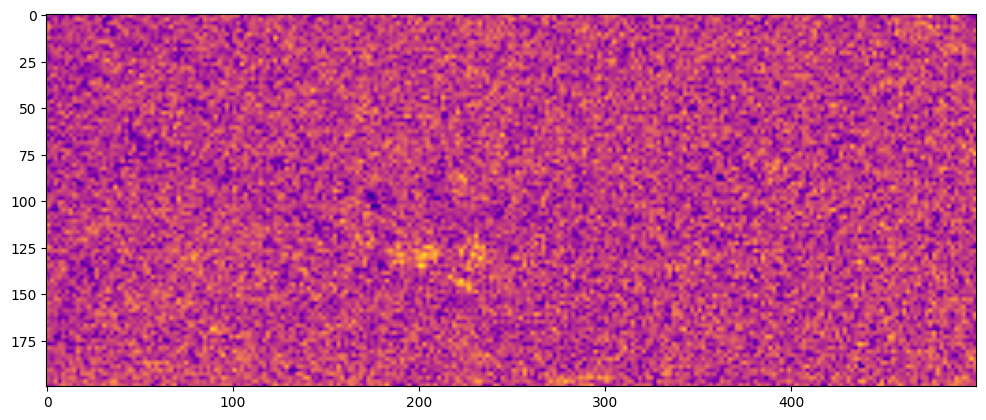

In [5]:
import xfmreadout.utils as utils
import matplotlib.pyplot as plt

ELEMENT = "Al"

vis.show_map(data, dims, elements, ELEMENT)

vis.show_map(sd, sd_dims, elements, ELEMENT)



CALCULATING EMBED
running reducer: UMAP across data with shape: (100000, 21)
UMAP(n_components=3, n_neighbors=30, verbose=True)
Tue Jul 11 15:30:17 2023 Construct fuzzy simplicial set
Tue Jul 11 15:30:17 2023 Finding Nearest Neighbors
Tue Jul 11 15:30:17 2023 Building RP forest with 21 trees
Tue Jul 11 15:30:23 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	Stopping threshold met -- exiting after 3 iterations
Tue Jul 11 15:30:46 2023 Finished Nearest Neighbor Search
Tue Jul 11 15:30:50 2023 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:33]


Tue Jul 11 15:31:42 2023 Finished embedding
CALCULATING CATS
RUNNING CLASSIFIER
---------------------------
CLASSIFICATION COMPLETE
---------------------------
total time: 93.81 s
time per pixel: 0.000938 s
---------------------------
cluster 0, count: 28721
cluster 1, count: 14976
cluster 2, count: 10415
cluster 3, count: 3380
cluster 4, count: 3874
cluster 5, count: 9773
cluster 6, count: 9613
cluster 7, count: 10296
cluster 8, count: 5597
cluster 9, count: 3355
(100000, 3)
running reducer: PCA across data with shape: (100000, 3)
[[ 0.2573263   7.18833     6.907647  ]
 [12.259929    6.6138372   7.67734   ]
 [ 8.072874    6.1765175   6.0027385 ]
 [-0.6571944   9.212946   -0.05297003]
 [ 0.30491588 10.324606    1.045748  ]
 [ 0.7117179  -0.45644823  5.5328546 ]
 [-1.2481265  -1.0644649   7.413856  ]
 [-0.6959498  10.139365   11.622923  ]
 [-0.26643145 12.168335    8.814424  ]
 [-0.49837476 11.730254   10.213893  ]]
[[0.5        0.5        0.5       ]
 [1.         0.58024776 0.66207445]

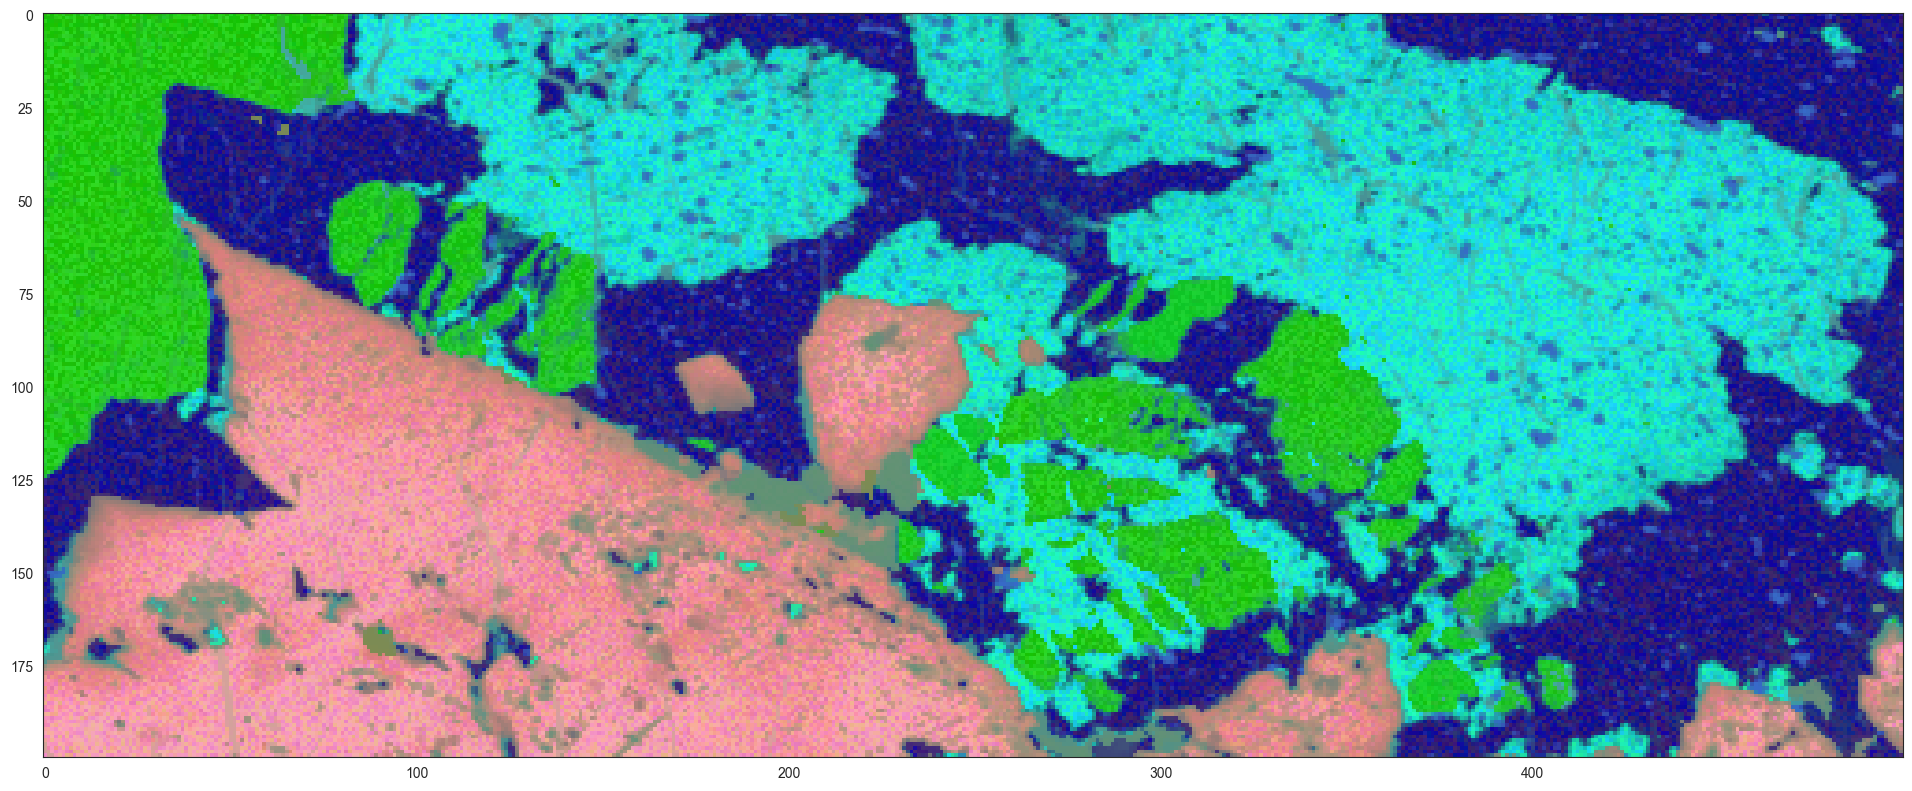

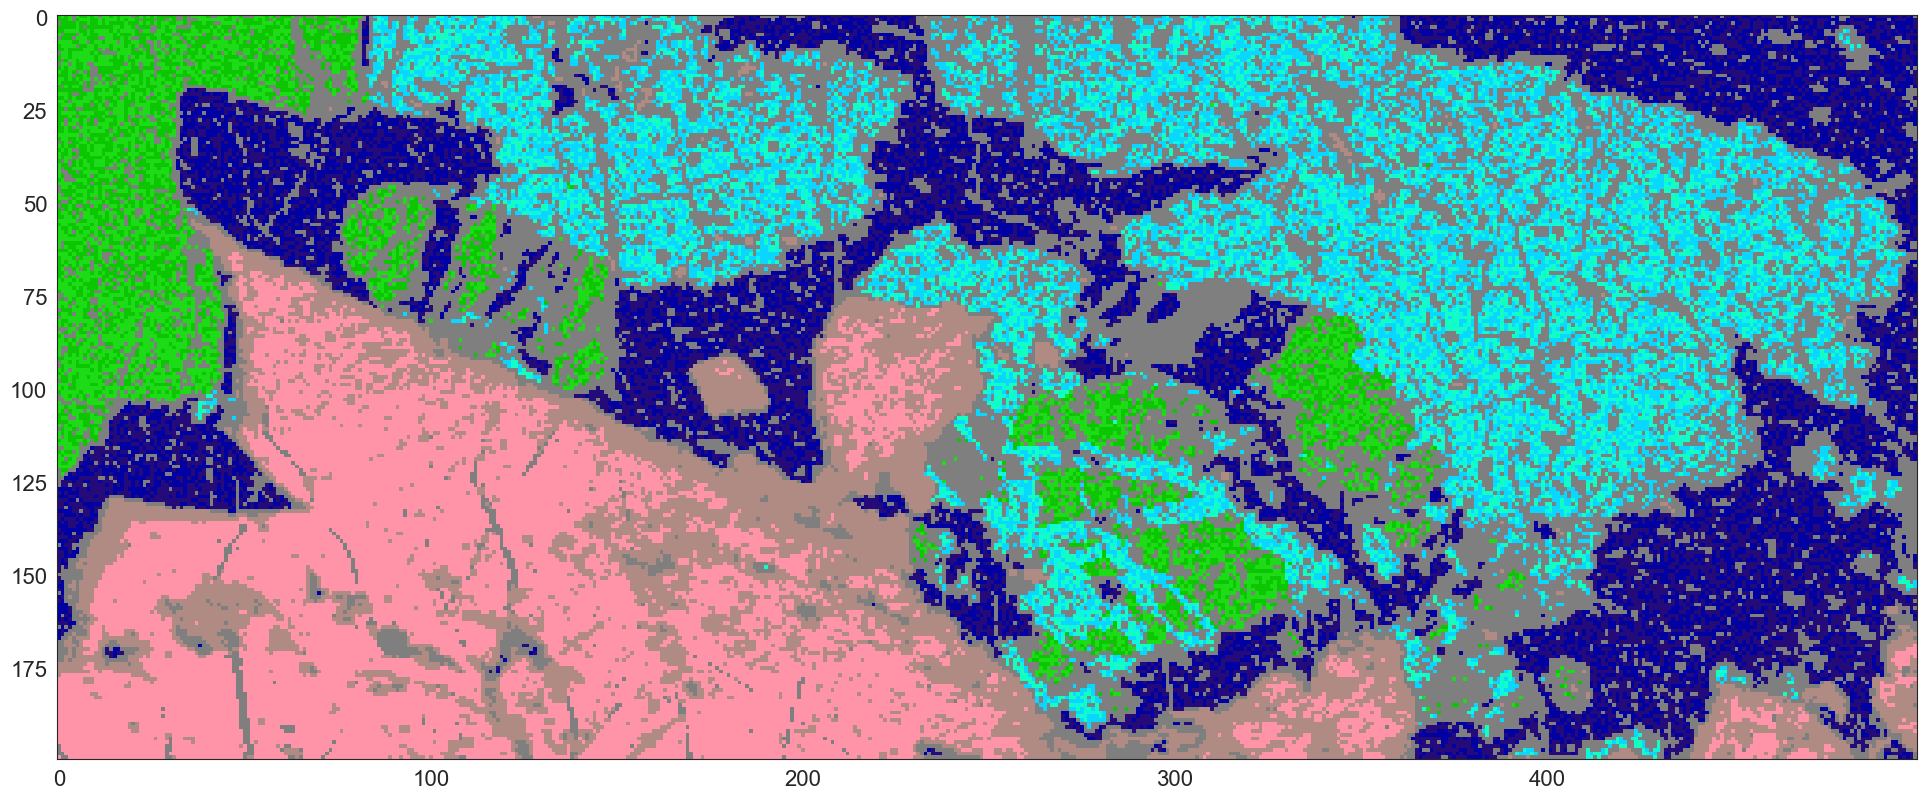

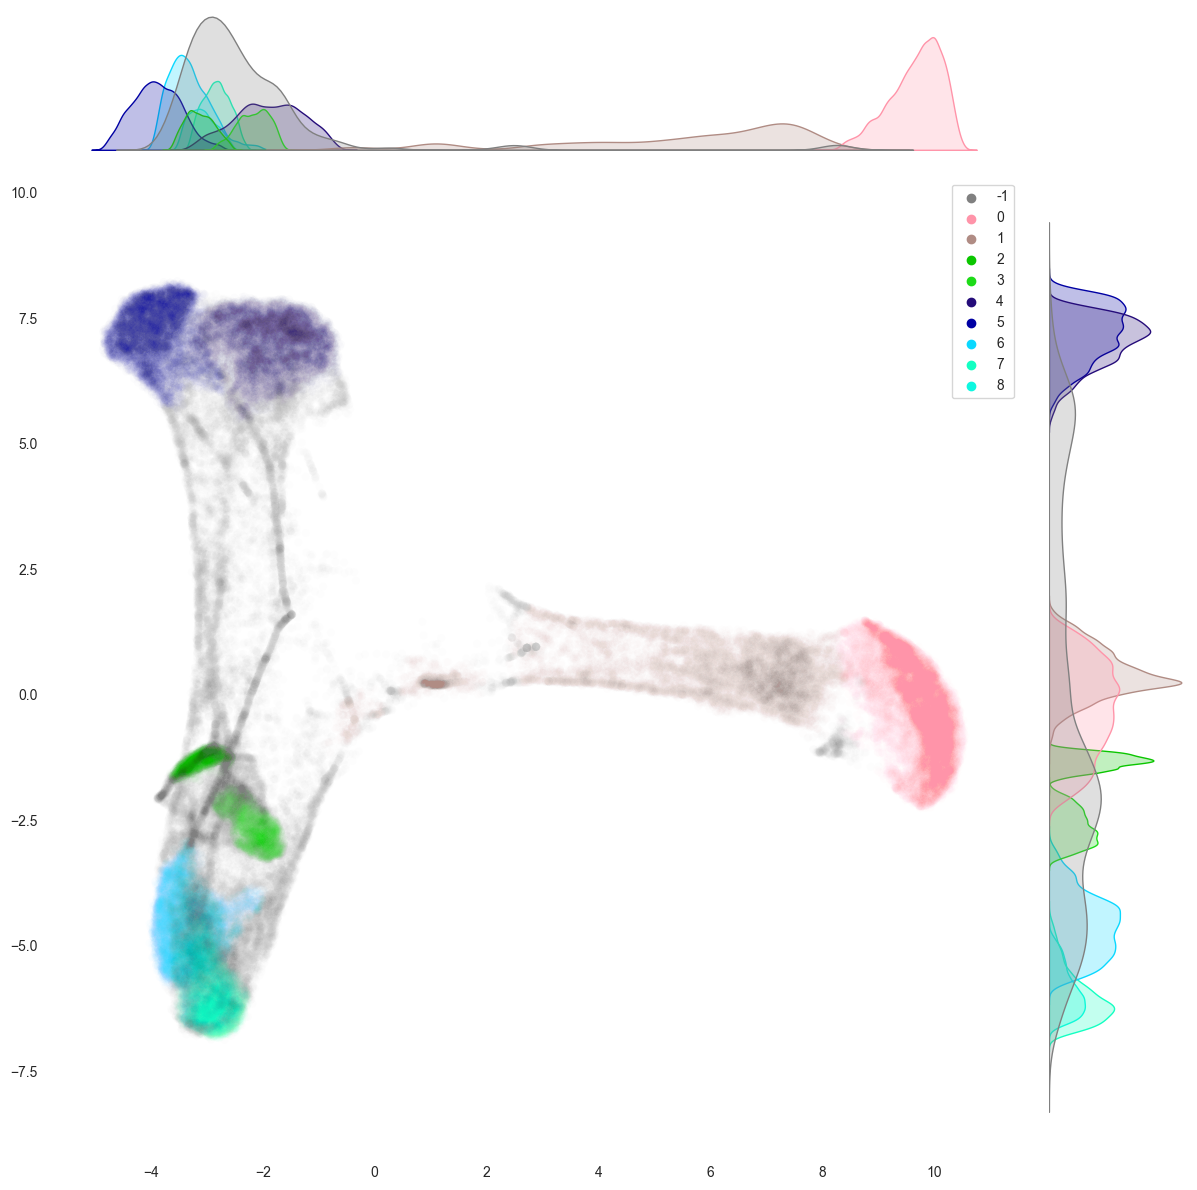

Al, max: 1.00, 98: 0.63, avg: 0.35
As, max: 0.72, 98: 0.01, avg: 0.00
Back, max: 0.00, 98: 0.00, avg: 0.00
Ca, max: 4.39, 98: 0.70, avg: 0.06
Cl, max: 0.05, 98: 0.04, avg: 0.02
Compton, max: 0.00, 98: 0.00, avg: 0.00
Cr, max: 0.04, 98: 0.03, avg: 0.01
Cu, max: 12.10, 98: 8.21, avg: 1.99
Fe, max: 18.14, 98: 13.61, avg: 7.77
K, max: 0.27, 98: 0.03, avg: 0.00
Mn, max: 10.03, 98: 0.22, avg: 0.03
Mo, max: 15.18, 98: 3.99, avg: 2.29
MoL, max: 0.78, 98: 0.50, avg: 0.22
Ni, max: 0.25, 98: 0.04, avg: 0.01
P, max: 0.06, 98: 0.04, avg: 0.02
S, max: 4.32, 98: 3.30, avg: 1.73
Si, max: 4.49, 98: 2.63, avg: 0.55
Ti, max: 2.78, 98: 0.03, avg: 0.01
V, max: 0.02, 98: 0.01, avg: 0.01
Zn, max: 62.07, 98: 1.81, avg: 0.21
sum, max: 0.00, 98: 0.00, avg: 0.00
CPU times: user 6min 47s, sys: 55.8 s, total: 7min 43s
Wall time: 1min 45s


In [8]:
%%time


FORCE_EMBED=True
FORCE_CLUST=True
OVERWRITE=True

weights = np.ones(data.shape[1], dtype=np.float32)
weights = processops.calc_weights(data, weights, do_sqrt=False) #weights unchanged
data_ = processops.apply_weights(data, weights)
data_ = np.sqrt(data_)


categories, embedding = clustering.run(data_, image_directory, force_embed=FORCE_EMBED, force_clust=FORCE_CLUST, overwrite=OVERWRITE)

classavg = clustering.get_classavg(data, categories, image_directory, force=FORCE_CLUST, overwrite=OVERWRITE)

palette = vis.plot_clusters(categories, classavg, embedding, dims, output_directory=output_directory)

for i in range(len(elements)):
    print(f"{elements[i]}, max: {np.max(data[:,i]):.2f}, 98: {np.quantile(data[:,i],0.98):.2f}, avg: {np.average(data[:,i]):.2f}")




In [9]:
import pandas as pd
from tabulate import tabulate

elements

df = pd.DataFrame(data=classavg, columns=elements)

df
#print(tabulate(df, headers='keys', tablefmt='psql'))

,Al,As,Back,Ca,Cl,Compton,Cr,Cu,Fe,K,...,Mo,MoL,Ni,P,S,Si,Ti,V,Zn,sum
0,0.082136,0.002893,3.412830e-11,0.000392,0.002527,4.206402e-10,0.000067,0.002837,0.000157,0.000022,...,3.245308,0.056848,0.000002,0.002260,0.332875,1.947449,0.000108,0.000026,0.000734,1.153810e-08
1,0.173293,0.003206,2.674412e-11,0.117893,0.006040,1.064378e-09,0.002075,0.248377,1.435538,0.000738,...,2.685432,0.107660,0.000268,0.007235,0.468551,1.613126,0.005540,0.001351,0.048605,2.136397e-08
2,0.338960,0.005483,1.256369e-11,0.009978,0.017030,2.943479e-09,0.011962,0.027249,8.738091,0.002796,...,1.675136,0.130091,0.000590,0.025341,3.128958,0.000224,0.009605,0.004699,0.002007,5.761654e-08
3,0.339703,0.005718,1.226083e-11,0.010007,0.016989,2.897304e-09,0.011851,0.029881,8.675905,0.002795,...,1.652062,0.130082,0.000625,0.025264,3.127319,0.150575,0.009561,0.004646,0.002266,5.749552e-08
4,0.471932,0.000371,1.933733e-11,0.023830,0.026475,3.763749e-09,0.021266,7.458025,8.808279,0.008721,...,1.926237,0.361363,0.018924,0.031521,1.836245,0.208677,0.019862,0.010502,0.088535,1.156992e-07
5,0.472687,0.000350,1.964281e-11,0.023640,0.026549,3.826592e-09,0.021479,7.484026,8.827511,0.008938,...,1.911133,0.360155,0.019363,0.031682,1.852090,0.000519,0.019955,0.010615,0.100495,1.158382e-07
6,0.432034,0.000983,1.326698e-11,0.027492,0.021957,3.284061e-09,0.021921,0.053785,12.628057,0.005579,...,2.160425,0.243082,0.000575,0.029727,2.246598,0.000289,0.017753,0.010112,0.023985,1.129713e-07
7,0.426736,0.000928,1.322315e-11,0.020210,0.021954,3.277060e-09,0.021971,0.037638,12.764532,0.005886,...,2.169358,0.243612,0.000463,0.029593,2.249766,0.216625,0.017772,0.010200,0.013463,1.140315e-07
8,0.431226,0.000914,1.299583e-11,0.018220,0.022027,3.300809e-09,0.022082,0.032640,12.726982,0.005183,...,2.186000,0.241493,0.000495,0.029750,2.260645,0.035664,0.017883,0.010230,0.011459,1.145079e-07
9,0.411391,0.003112,1.736105e-11,0.146581,0.021258,3.495201e-09,0.018235,1.744951,9.898450,0.005370,...,2.148102,0.250012,0.006969,0.028443,2.141403,0.163210,0.018069,0.008518,0.622416,9.376581e-08


In [16]:
n_clusters = len(category_list)

for i in range(n_clusters):
    print(i)

0
1
2
3
4
5
6
7
8
9
10


In [46]:
import seaborn as sns
import colorcet as cc

import xfmreadout.utils as utils
import xfmreadout.visualisations as vis

#palette2=vis.build_palette(categories)

GREY=( 0.5, 0.5, 0.5 )

cat_min=np.min(categories)
cat_max=np.max(categories)
num_cats=cat_max-cat_min+1
num_colours = num_cats*4

palette = sns.color_palette(cc.glasbey_light,num_colours)

colours = np.array(palette, dtype=np.float32)

# produce 2D embedding for visualisation
___, colour_embedding = clustering.reduce(colours, "UMAP", target_components=2) 

centroids = utils.compile_centroids(embedding, categories)

    

running reducer: UMAP across data with shape: (90, 3)
UMAP(n_neighbors=30, verbose=True)
Tue Jul 11 16:32:21 2023 Construct fuzzy simplicial set
Tue Jul 11 16:32:21 2023 Finding Nearest Neighbors
Tue Jul 11 16:32:21 2023 Finished Nearest Neighbor Search
Tue Jul 11 16:32:21 2023 Construct embedding


Epochs completed: 100%| ██████████ 500/500 [00:03]

Tue Jul 11 16:32:25 2023 Finished embedding


10

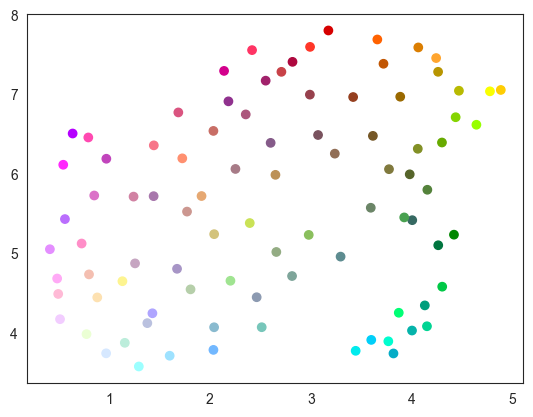

In [47]:
plt.scatter(colour_embedding[:,0], colour_embedding[:,1], c=colours)

num_cats

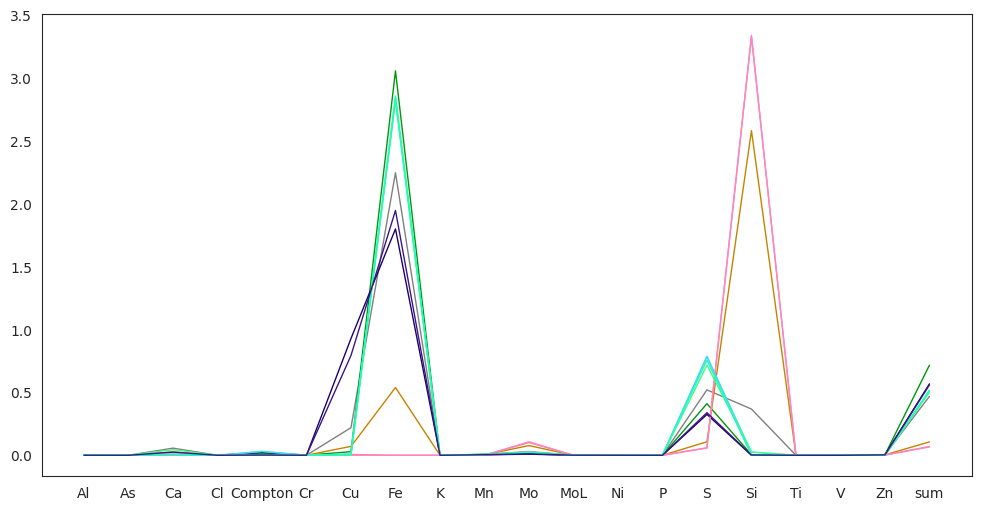

In [40]:
from matplotlib import colors

vis.category_avgs(categories, elements, classavg, palette=palette)